# Q4: Estimating the masses of apples [Object Area Calculation]


In [21]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.cluster import KMeans

In [22]:
json_path = "../Result/Counting/json/"
img_path = "../Attachment/Attachment 1/"

### 2. Algorithm

In [23]:
# Cropping 185 270
def cropImg(img,circle):
    point1, point2 = circle['point']
    radius = circle['radius']
    x1 = round(point1-radius) if round(point1-radius) > 0 else 0
    y1 = round(point2-radius) if round(point2-radius) > 0 else 0
    x2 = round(point1+radius) if round(point1+radius) < 270 else 270
    y2 = round(point2+radius) if round(point2+radius) < 185 else 185
    crop_img = img[y1:y2,x1:x2]
    return crop_img


In [24]:
# Distinguish Ripness By Color
def IdentifyRipeness(color):
    ripeness = {
        "low_raw" : np.array([80, 100, 50]), "high_raw" : np.array([150, 180, 120]),
        "low_red_ripe": np.array([160, 0, 0]), "high_red_ripe": np.array([255, 120, 100]),
        "low_yellow_ripe":np.array([180, 180, 0]), "high_yellow_ripe": np.array([255, 255, 80]),
        "low_green_ripe":np.array([0, 120, 50]), "high_green_ripe": np.array([100, 200, 100])
    }
    def d2(color,Icolor):
        color = np.power(np.subtract(color,Icolor),2)
        d = np.sqrt(np.sum(color))
        return d
    min_mse = 1e10
    ans = ""
    for i,j in ripeness.items():
        d = d2(color,j)
        if d < min_mse:
            ans = i
            min_mse = d
    return ans

In [25]:
def kmeans(k, img):
    img1 = img.reshape((-1,3))
    model = KMeans(k).fit(img1)
    clusters = model.cluster_centers_
    labels = model.labels_
    segmented_image = clusters[labels].reshape(img.shape).astype(np.uint8)
    return segmented_image

In [26]:
# grabCut
def GrabCut(img):
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    rect = (0, 0, img.shape[1]-1,img.shape[0]-1)
    iterCount = 5
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    img = img * mask2[:,:,np.newaxis]
    return img

In [27]:
def meanExceptBlack(img):
    shape = img.shape
    width, height = shape[1], shape[0]
    point = round(width/2), round(height/2)
    radius = width if width < height else height
    _mean = 0
    m = np.array([0,0,0])
    for y in range(height):
        for x in range(width):
            distance = np.sqrt((x - point[0])**2 + (y - point[1])**2)
            if distance <= radius and not np.array_equal(img[y][x],np.array([0,0,0])):
                m += img[y][x]
                _mean += 1
    if _mean > 0:
        return m/_mean
    else:
        return np.array([0,0,0])

In [28]:
def classificationColor(img,colors,n=2):
    ans = []
    shape = img.shape
    def d2(color,Icolor):
        color = np.power(np.subtract(color,Icolor),2)
        d = np.sqrt(np.sum(color))
        return d
    def color_range(lists,color):
        for l in lists:
            if np.array_equal(l,color):
                return True
        return False

    reshaped_image = img.reshape(-1,img.shape[-1])
    unique_color = np.unique(reshaped_image, axis=0)
    for i,color in enumerate(unique_color):
        if not np.array_equal(color,np.array([0,0,0])):
            d = d2(color,colors)
            ans.append((d,i))
    if n > len(ans):
        n = len(ans)

    def first(elem):
        return elem[0]
    ans.sort(key=first)
    l = [unique_color[ ans[i][1] ] for i in range(n)]
    area = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            if color_range(l,img[i][j]):
                img[i][j] = colors
                area += 1
            else:
                img[i][j] = np.array([0, 0 ,0])
    return img,area

In [29]:
# Maturity and Ripeness of Apples (Q3,Q4)
def question4(json_file, image_file):
    Q_4 = []
    with open(json_file,'r') as file:
        data_label = json.load(file)
    data_img = cv2.imread(image_file)
    data_img = data_img[:,:,::-1]
    for circle in data_label:
        # Crop Image
        crop_img = cropImg(data_img, circle)

        # Resizing
        crop_img = cv2.resize(crop_img,(100,100),fx=0.8,fy=0.8,interpolation=2)

        # Grabcut
        grabcut_img = GrabCut(crop_img)

        # KMeans for considering Ripness
        kMeans_img = kmeans(k=5, img=grabcut_img)
        color = meanExceptBlack(kMeans_img)

        # Classify Colors and Computing Areas
        c_img, area = classificationColor(kMeans_img,color,n=3)
        area = round(area * (crop_img.shape[0]*crop_img.shape[1]) / (100*100), 3)
        mass = round(0.7 * area,3)
        Q_4.append(mass)
    return Q_4


### 3. Evaluation

In [30]:
Q4_ans = []

for i in range(1,201):
    json_file = json_path + str(i) + ".json"
    img_file = img_path + str(i) + ".jpg"
    Q4 = question4(json_file,img_file)
    for q4 in Q4:
        Q4_ans.append(q4)

d:\Download\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


d:\Download\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Download\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Download\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Download\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

### 4. Plot Histogram

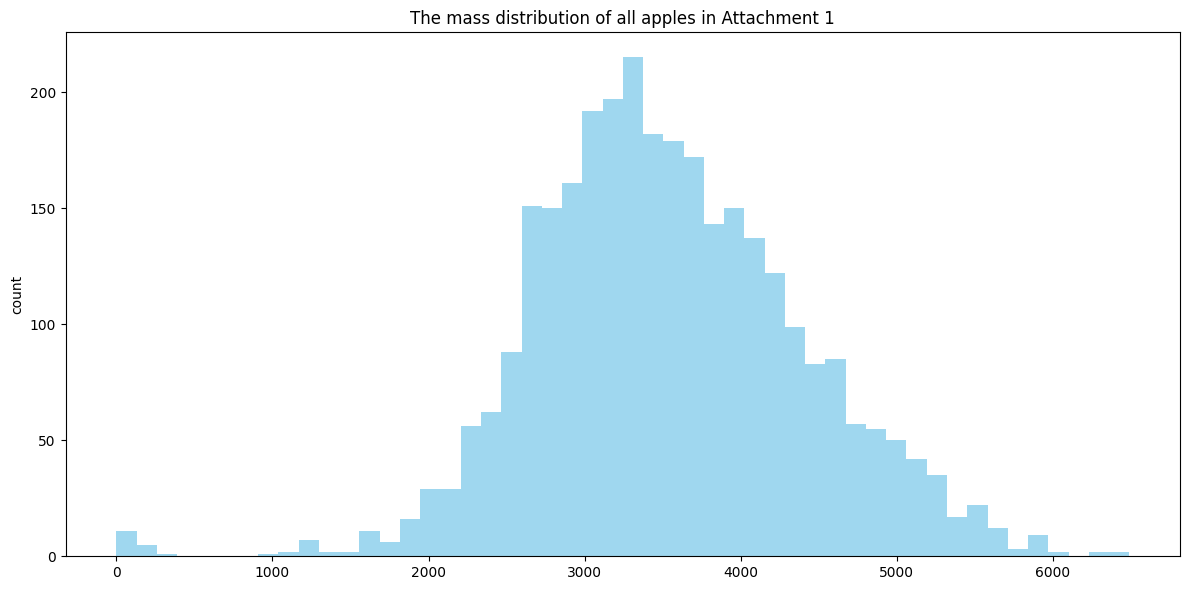

In [32]:
plt.figure(figsize=(12,6))

plt.subplot()
plt.title("The mass distribution of all apples in Attachment 1")
plt.hist(Q4_ans,bins=50,color='skyblue', alpha=0.8)
plt.ylabel("count")

plt.tight_layout()
plt.show()